In [1]:
import numpy as np

file_path = 'data/large_scan.xyz'  
data = np.loadtxt(file_path, delimiter=',')
point_sum = data[:, :3] 
color_sum = data[:, 3:6] /255 
print("success load!")


success load!


In [7]:
print(point_sum.shape)

(1921521, 3)


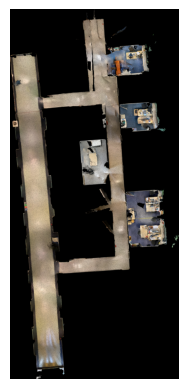

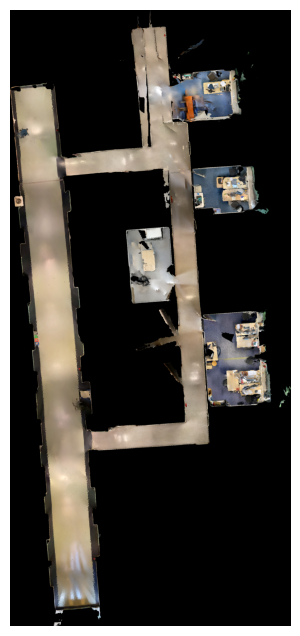

In [3]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

scale = 1 / 0.01
# top-view
mask_v = point_sum[:, 1] <= 1.5
points_v = point_sum[mask_v]
colors_v = color_sum[mask_v]

x_v = np.rint(points_v[:, 0] * scale).astype(np.int32)
y_v = np.rint(points_v[:, 2] * scale).astype(np.int32)

# for obstacle
mask_o = (point_sum[:, 1] <= 1.0) & (point_sum[:, 1] >0.8)
points_o = point_sum[mask_o]

x_o = np.rint(points_o[:, 0] * scale).astype(np.int32)
y_o = np.rint(points_o[:, 2] * scale).astype(np.int32)

x_min = min(x_v.min(), x_o.min())
x_max = max(x_v.max(), x_o.max())
y_min = min(y_v.min(), y_o.min())
y_max = max(y_v.max(), y_o.max())

x_v -= x_min
y_v -= y_min

# Determine the grid dimensions
map_width = x_max - x_min + 1
map_height = y_max - y_min + 1

# Create an image to store RGB colors
top_view_map = np.zeros((map_height, map_width, 3), dtype=np.uint8)
z_buffer = np.full((map_height, map_width), -np.inf)
# Iterate over points
for i in range(len(points_v)):
    if points_v[i, 1] > z_buffer[y_v[i], x_v[i]]:
        z_buffer[y_v[i], x_v[i]] = points_v[i, 1]
        top_view_map[y_v[i], x_v[i]] = (colors_v[i] * 255).astype(np.uint8)

# creat the obstacle map

x_o -= x_min
y_o -= y_min
obstacle_map = np.zeros((map_height, map_width), dtype=np.uint8)
obstacle_map[y_o, x_o] = 1

gray_map_cv = cv2.cvtColor(top_view_map, cv2.COLOR_RGB2GRAY)
obstacle_empty_map = np.zeros(obstacle_map.shape)
obstacle_empty_map[gray_map_cv != 0] = 1
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
ob_map = cv2.dilate((obstacle_empty_map).astype('uint8'), kernel)
ob_map = cv2.erode((ob_map).astype('uint8'), kernel)

obstacle_map[ob_map == 0] = 1

top_view_map_show = Image.fromarray(top_view_map)
top_view_map_show.save("real_top_view_map.png")
plt.imshow(top_view_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

# 定义结构元素
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# 应用闭操作
closed_map = cv2.morphologyEx(top_view_map, cv2.MORPH_CLOSE, kernel)

closed_map = Image.fromarray(closed_map)
closed_map.save("real_closed.png")
plt.figure(figsize=(10, 8)) 
plt.imshow(closed_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

    

In [3]:
print(closed_map.shape)

(4225, 1893, 3)


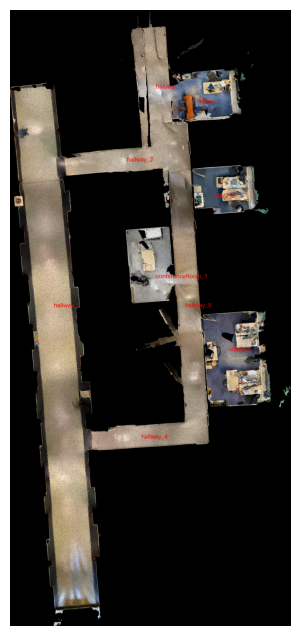

(4225, 1926, 3)


In [14]:
scene_names = ["hallway_1", "hallway_2", "hallway_3", "hallway_4", "hallway_5", "office_1", "office_2", "office_3", "conferenceRoom_1"]
pos = [(1000, 500), (800, 1000), (300, 2000), (900, 2900), (1200, 2000), (1300, 600), (1400, 1250), (1500, 2300), (1000, 1800)]
all_centers = {}
for i in range(len(scene_names)):
    all_centers[scene_names[i]] = (pos[i][1], pos[i][0])
    
   
from PIL import Image, ImageDraw, ImageFont
pil_image = Image.fromarray(top_view_map)
        
# add the number on the image
# Initialize drawing context
draw = ImageDraw.Draw(pil_image)
# Define the text to be added and its position
font_size = 40

try:
    # Attempt to use a truetype font if available
    font = ImageFont.truetype("arial.ttf", font_size)
except IOError:
    # If the truetype font is not available, use the default PIL font
    font = ImageFont.load_default(font_size)

# Add text to image
for name, pos in all_centers.items():
    draw.text((pos[1], pos[0]), name, fill="red", font=font)
        
plt.figure(figsize=(10, 8)) 
plt.imshow(pil_image)
plt.axis('off')  # 隐藏坐标轴
plt.show()
print(top_view_map.shape)

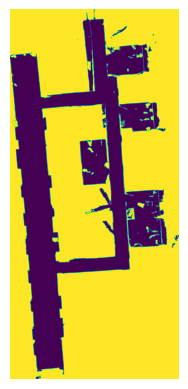

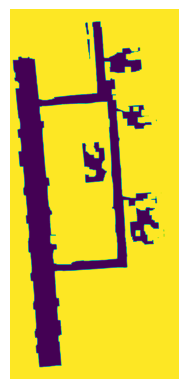

In [25]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(50, 50))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

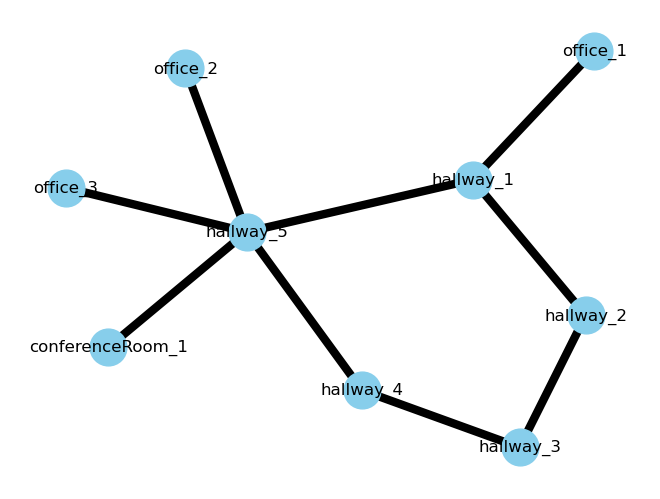

In [23]:
import networkx as nx

G = nx.Graph()
for name in scene_names:
        G.add_node(name)
        
G.add_edge("office_1", "hallway_1")
G.add_edge("office_2", "hallway_5")
G.add_edge("office_3", "hallway_5")
G.add_edge("conferenceRoom_1", "hallway_5")
G.add_edge("hallway_4", "hallway_5")
G.add_edge("hallway_4", "hallway_3")
G.add_edge("hallway_2", "hallway_3")
G.add_edge("hallway_2", "hallway_1")
G.add_edge("hallway_5", "hallway_1")

import path_finding
path_finding.graph_show(G)

In [31]:
import cv2
import numpy as np
from io import BytesIO
import os
import importlib
importlib.reload(path_finding)
# all possible topo path searching

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_real/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

All paths from node office_1 to node office_3 :
2 ['office_1', 'office_3']
5 ['office_1', 'hallway_2', 'hallway_3', 'hallway_4', 'office_3']
2
['office_1', 'office_3']
['office_1', 'hallway_2', 'hallway_3', 'hallway_4', 'office_3']


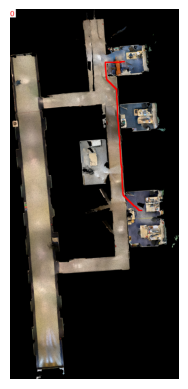

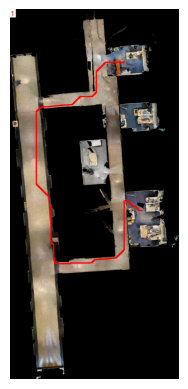

In [32]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt


navigation_instruct = "send a classified file from an office to another office"

source_nodes = ["office_1"]
target_nodes = ["office_3"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)

        
    
    



In [37]:
importlib.reload(chat_utils)


message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
        
response_message = chat_utils.chat_with_gpt4v(message)
ground_json = ast.literal_eval(response_message)
print(ground_json["path_id"])
index = int(ground_json["path_id"])

gpt-4o response: 
{
    "observation": "The two paths provided for transporting a classified file between offices have distinct routes through the building. Path 0 appears to take a more direct route through fewer rooms, while Path 1 takes a longer route but avoids the central open areas.",
    "reason": "For transporting a classified file, the primary concern should be minimizing exposure to potential unauthorized observers. Path 0, although more direct, passes through several office spaces where the risk of human presence and potential observation is higher. Path 1, on the other hand, circumvents these areas by taking a longer route around the perimeter, thus potentially reducing the risk of the file being seen by unintended parties. Given the need for privacy and minimizing human interaction, Path 1 is more suitable despite its longer distance.",
    "self-critique": "The analysis assumes that fewer visible office spaces correlate directly with lesser risk, which might not always ho